In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt
import pytz

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")
sys.path.append("../src/tests")

In [3]:
import clustering as clstr
import bout.assembly as bt
import plot as bt_plt
import test_activity_metric_functions as test_actvt
import activity.subsampling as ss
import activity.activity_assembly as actvt
import pipeline
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS

from cli import get_file_paths
import pipeline

In [4]:
def plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')

    UBNA_tz = pytz.timezone('US/Pacific')
    UTC_tz = pytz.timezone('UTC')

    file_dt_UTC = UTC_tz.localize(file_dt)
    file_dt_PST = file_dt_UTC.astimezone(UBNA_tz)
    file_title = f'{file_dt_PST.date()} {file_dt_PST.time()} PST'

    on = int(data_params['cur_dc_tag'].split('of')[0])
    total = int(data_params['cur_dc_tag'].split('of')[1])

    plt.figure(figsize=audio_features['figsize'])
    plt.rcParams.update({'font.size': 24})
    plt.title(f"Audiomoth file recorded at {file_title}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmax=0, vmin=spec_features['vmin'])

    green_patch = patches.Patch(facecolor='lightgreen', edgecolor='k', label='Recording period')
    blue_patch = patches.Patch(facecolor='royalblue', edgecolor='k', label='Sleep period')
    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detected calls')
    orange_patch = patches.Patch(facecolor='orange', edgecolor='k', label='High-frequency calls')
    cyan_patch = patches.Patch(facecolor='cyan', edgecolor='k', label='Low-frequency calls')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=1, edgecolor='yellow', facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)


    windows_PST = pd.date_range(file_dt_PST+pd.Timedelta(seconds=start), file_dt_PST+pd.Timedelta(seconds=start)+pd.Timedelta(seconds=duration), freq=f'{duration//300}T', inclusive='both')

    plt.yticks(ticks=np.linspace(0, 1*(96/125), 6), labels=np.linspace(0, 192000/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), len(windows_PST)), labels=windows_PST.strftime('%-M'), color='k')
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (minutes)")
    plt.ylim(0, 96/125)
    plt.legend(handles=legend_patches, fontsize=14, ncol=1, loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_dets, plot_bouts):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed bouts and bout duurations.
    """
    
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')

    UBNA_tz = pytz.timezone('US/Pacific')
    UTC_tz = pytz.timezone('UTC')

    file_dt_UTC = UTC_tz.localize(file_dt)
    file_dt_PST = file_dt_UTC.astimezone(UBNA_tz)
    file_title = f'{file_dt_PST.date()} {file_dt_PST.time()} PST'

    plt.figure(figsize=audio_features['figsize'])
    plt.rcParams.update({'font.size': 24})
    plt.title(f"BCI-derived bouts using BD2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    legend_patches = []
    for group in bout_params.keys():
        type_tag = group.split('_')[0]
        
        if group != 'site_key' and (type_tag in plot_bouts['freq_group'].values):
            group_tag = group.split('_')[0]
            group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'{type_tag.upper()} Bout')
            legend_patches += [group_patch]

    ax = plt.gca()
    plot_bout_info(ax, audio_features, plot_bouts)
    if len(plot_dets)>0:
        for i, row in plot_dets.iterrows():
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=1, edgecolor='yellow', facecolor='none', alpha=0.8)
            
            ax.add_patch(rect)
    
    windows_PST = pd.date_range(file_dt_PST+pd.Timedelta(seconds=start), file_dt_PST+pd.Timedelta(seconds=start)+pd.Timedelta(seconds=duration), freq=f'{duration//300}T', inclusive='both')

    plt.yticks(ticks=np.linspace(0, 1*(96/125), 6), labels=np.linspace(0, 192000/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), len(windows_PST)), labels=windows_PST.strftime('%-M'), color='k')
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (minutes)")
    plt.ylim(0, 96/125)
    # plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=14, ncol=int(len(legend_patches)), loc='upper right')

    plt.tight_layout()
    plt.show()


def plot_bout_info(ax, audio_features, plot_bouts):
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    for i, row in plot_bouts.iterrows():
        # if duration < 600:
            # plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+2000)/(fs/2), 9/10), 
            #                     s=f"{round(row['bout_duration_in_secs'], 2)}s", color='pink', weight='bold', fontsize=9)
            # plt.text(x=(row['start_time'] - start + (row['bout_duration_in_secs']/5))*(fs/2), y=min((row['high_freq']+12000)/(fs/2), 9/10), 
            #                     s=f"{round(row['number_of_dets'], 2)} dets", color='pink', weight='bold', fontsize=9)
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['bout_duration_in_secs'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['freq_group']], facecolor='none', alpha=0.8)
        ax.add_patch(rect)

In [5]:
site_key = 'Carp'
freq_key = ''

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = freq_key
data_params['detector_tag'] = 'bd2'
data_params['use_thresholds'] = True
data_params['use_kmeans'] = False
data_params['recording_start'] = '00:00'
data_params['recording_end'] = '16:00'
file_paths = get_file_paths(data_params)

location_df = pd.read_csv(f'{file_paths["SITE_folder"]}/{file_paths["detector_TYPE_SITE_YEAR"]}.csv', index_col=0)
bout_params = bt.get_bout_params_from_location(location_df, data_params)

In [6]:
bout_params

{'site_key': 'Carp',
 'LF1_bci': 2416.7440754694976,
 'HF1_bci': 1089.5931708212388,
 'HF2_bci': 593.2153147328188}

In [7]:
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))
files_from_loc

[PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220727_080000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_030000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_033000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_040000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_043000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_050000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_053000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_060000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_063000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_070000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_073000.WAV'),
 PosixPath('../data/audiomoth_recordings/recover-20220

In [8]:
file = files_from_loc[11]
file

PosixPath('../data/audiomoth_recordings/recover-20220728/Carp/20220728_080000.WAV')

In [9]:
file_path = Path(file)
filename = file_path.name
audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 0
duration = 1800
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmax = 20*np.log10(np.max(audio_seg)) # hide anything below -rm_dB dB
vmin = 20*np.log10(np.max(audio_seg)) - 60 # hide anything below -rm_dB dB
data_params['cur_dc_tag'] = '30of30'
data_params['cycle_length'] = int(data_params['cur_dc_tag'].split('of')[-1])
data_params['time_on'] = int(data_params['cur_dc_tag'].split('of')[0])
data_params['time_on_in_secs'] = 60*data_params['time_on']
data_params['recording_alpha'] = 0.0

file_dt_start = dt.datetime.strptime(filename, '%Y%m%d_%H%M%S.WAV')
file_dt_end = file_dt_start + pd.Timedelta(minutes=30)

In [10]:
dc_applied_df = ss.simulate_dutycycle_on_detections(location_df.copy(), data_params)
bout_metrics = bt.generate_bout_metrics_for_location_and_freq(dc_applied_df, data_params, bout_params)

In [11]:
plot_dets = dc_applied_df.loc[(dc_applied_df['call_start_time']>=file_dt_start)&(dc_applied_df['call_end_time']<=file_dt_end)]
plot_dets = plot_dets.loc[np.logical_and(plot_dets['start_time'] >= start, plot_dets['end_time'] <= (start+duration))]
plot_dets

start_time_wrt_ref  end_time_wrt_ref freq_group  index_in_file  \
242761              5.8035            5.8132        HF1              0   
242762              6.1035            6.1126        HF1              1   
242763              6.2085            6.2189        HF1              2   
242764              6.4205            6.4304        HF1              3   
242765              6.5275            6.5377        HF1              4   
...                    ...               ...        ...            ...   
247187           1794.1435         1794.1580        LF1           4426   
247188           1794.3755         1794.3911        LF1           4427   
247189           1794.6075         1794.6260        LF1           4428   
247190           1794.7165         1794.7290        LF1           4429   
247191           1794.9945         1795.0047        LF1           4430   

                            ref_time               call_start_time  \
242761 2022-07-28 08:00:05.803500000 2022-07-28 08:00:05.803500000   
242762 2022-07-28 08:00:06.103500000 2022-07-28 08:00:06.103500000   
242763 2022-07-28 08:00:06.208500000 2022-07-28 08:00:06.208500000   
242764 2022-07-28 08:00:06.420500000 2022-07-28 08:00:06.420500000   
242765 2022-07-28 08:00:06.527499999 2022-07-28 08:00:06.527499999   
...                              ...                           ...   
247187 2022-07-28 08:29:54.143500000 2022-07-28 08:29:54.143500000   
247188 2022-07-28 08:29:54.375500000 2022-07-28 08:29:54.375500000   
247189 2022-07-28 08:29:54.607500000 2022-07-28 08:29:54.607500000   
247190 2022-07-28 08:29:54.716500000 2022-07-28 08:29:54.716500000   
247191 2022-07-28 08:29:54.994500000 2022-07-28 08:29:54.994500000   

                    call_end_time  start_time   end_time  low_freq  ...  \
242761 2022-07-28 08:00:05.813200      5.8035     5.8132   37500.0  ...   
242762 2022-07-28 08:00:06.112600      6.1035     6.1126   37500.0  ...   
242763 2022-07-28 08:00:06.218900      6.2085     6.2189   37500.0  ...   
242764 2022-07-28 08:00:06.430400      6.4205     6.4304   37500.0  ...   
242765 2022-07-28 08:00:06.537700      6.5275     6.5377   36640.0  ...   
...                           ...         ...        ...       ...  ...   
247187 2022-07-28 08:29:54.158000   1794.1435  1794.1580   22890.0  ...   
247188 2022-07-28 08:29:54.391100   1794.3755  1794.3911   22890.0  ...   
247189 2022-07-28 08:29:54.626000   1794.6075  1794.6260   22890.0  ...   
247190 2022-07-28 08:29:54.729000   1794.7165  1794.7290   25468.0  ...   
247191 2022-07-28 08:29:55.004700   1794.9945  1795.0047   25468.0  ...   

                        class class_prob det_prob  individual  \
242761  Pipistrellus nathusii      0.459    0.577          -1   
242762  Pipistrellus nathusii      0.378    0.538          -1   
242763  Pipistrellus nathusii      0.405    0.536          -1   
242764  Pipistrellus nathusii      0.482    0.611          -1   
242765  Pipistrellus nathusii      0.450    0.591          -1   
...                       ...        ...      ...         ...   
247187      Nyctalus leisleri      0.488    0.648          -1   
247188      Nyctalus leisleri      0.565    0.629          -1   
247189      Nyctalus leisleri      0.361    0.540          -1   
247190      Nyctalus leisleri      0.611    0.676          -1   
247191      Nyctalus leisleri      0.502    0.618          -1   

                                               input_file  Site name  \
242761  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
242762  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
242763  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
242764  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
242765  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
...                                                   ...        ...   
247187  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
247188  /mnt/ubna_da

In [12]:
plot_bouts = bout_metrics.loc[(bout_metrics['start_time_of_bout']>=file_dt_start)&(bout_metrics['end_time_of_bout']<=file_dt_end)]
plot_bouts = plot_bouts.loc[np.logical_and(plot_bouts['start_time'] >= start, plot_bouts['end_time'] <= (start+duration))]
plot_bouts

start_time_of_bout           end_time_of_bout  \
6885 2022-07-28 08:01:19.016500 2022-07-28 08:01:39.590800   
6886 2022-07-28 08:05:04.580500 2022-07-28 08:05:06.350400   
6887 2022-07-28 08:05:32.456500 2022-07-28 08:05:38.101000   
6888 2022-07-28 08:05:46.985500 2022-07-28 08:05:49.580500   
6889 2022-07-28 08:06:10.801500 2022-07-28 08:06:15.039600   
...                         ...                        ...   
1559 2022-07-28 08:27:08.876500 2022-07-28 08:27:13.788100   
1560 2022-07-28 08:28:06.073500 2022-07-28 08:28:07.539500   
1561 2022-07-28 08:29:20.677500 2022-07-28 08:29:21.526000   
1562 2022-07-28 08:29:28.255500 2022-07-28 08:29:28.550200   
1563 2022-07-28 08:29:29.984500 2022-07-28 08:29:33.350900   

      start_time_wrt_ref  end_time_wrt_ref  start_time   end_time  low_freq  \
6885             79.0165           99.5908     79.0165    99.5908   25468.0   
6886            304.5805          306.3504    304.5805   306.3504   26328.0   
6887            332.4565          338.1010    332.4565   338.1010   26328.0   
6888            346.9855          349.5805    346.9855   349.5805   26328.0   
6889            370.8015          375.0396    370.8015   375.0396   25468.0   
...                  ...               ...         ...        ...       ...   
1559           1628.8765         1633.7881   1628.8765  1633.7881   37500.0   
1560           1686.0735         1687.5395   1686.0735  1687.5395   34062.0   
1561           1760.6775         1761.5260   1760.6775  1761.5260   36640.0   
1562           1768.2555         1768.5502   1768.2555  1768.5502   35781.0   
1563           1769.9845         1773.3509   1769.9845  1773.3509   34921.0   

      high_freq freq_group cycle_ref_time_start  cycle_ref_time_end  \
6885    40339.0        LF1  2022-07-28 08:00:00 2022-07-28 08:00:00   
6886    30524.0        LF1  2022-07-28 08:00:00 2022-07-28 08:00:00   
6887    31954.0        LF1  2022-07-28 08:00:00 2022-07-28 08:00:00   
6888    32864.0        LF1  2022-07-28 08:00:00 2022-07-28 08:00:00   
6889    32447.0        LF1  2022-07-28 08:00:00 2022-07-28 08:00:00   
...         ...        ...                  ...                 ...   
1559    51491.0        HF1  2022-07-28 08:00:00 2022-07-28 08:00:00   
1560    42120.0        HF1  2022-07-28 08:00:00 2022-07-28 08:00:00   
1561    43662.0        HF1  2022-07-28 08:00:00 2022-07-28 08:00:00   
1562    46425.0        HF1  2022-07-28 08:00:00 2022-07-28 08:00:00   
1563    52627.0        HF1  2022-07-28 08:00:00 2022-07-28 08:00:00   

      number_of_dets          bout_duration  bout_duration_in_secs  
6885              70 0 days 00:00:20.574300                20.5743  
6886               2 0 days 00:00:01.769900                 1.7699  
6887               6 0 days 00:00:05.644500                 5.6445  
6888               7 0 days 00:00:02.595000                 2.5950  
6889               9 0 days 00:00:04.238100                 4.2381  
...              ...                    ...                    ...  
1559              19 0 days 00:00:04.911600                 4.9116  
1560               4 0 days 00:00:01.466000                 1.4660  
1561               3 0 days 00:00:00.848500                 0.8485  
1562               2 0 days 00:00:00.294700                 0.2947  
1563              18 0 days 00:00:03.366400                 3.3664  

[209 rows x 14 columns]

In [13]:
audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
audio_features['figsize'] = (12, 5)

spec_features = dict()
spec_features['vmax'] = vmax
spec_features['vmin'] = vmin
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'

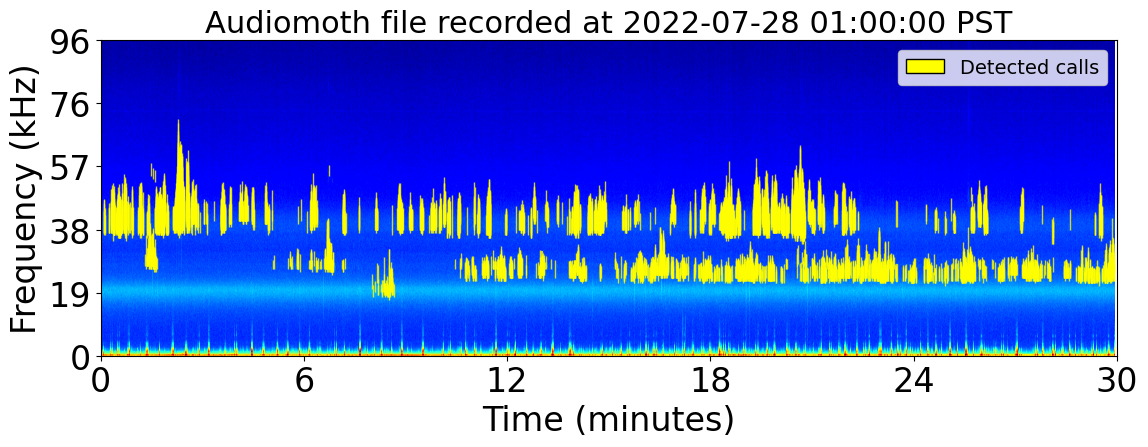

In [14]:
plot_dets_over_audio_seg(audio_features, spec_features, plot_dets, data_params)

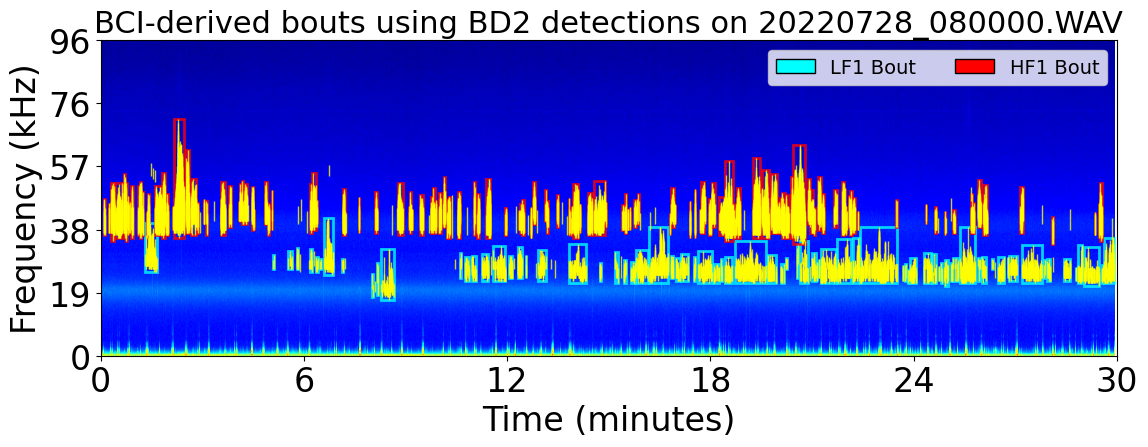

In [15]:
plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, plot_dets, plot_bouts)

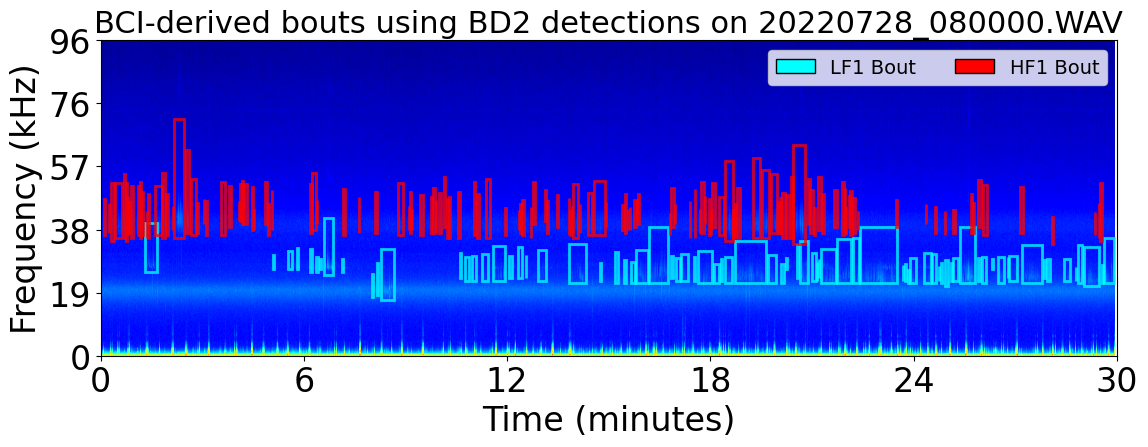

In [16]:
plot_bouts_over_audio_seg(audio_features, spec_features, bout_params, data_params, pd.DataFrame(), plot_bouts)

In [75]:
bouts_in_file = plot_bouts.loc[(plot_bouts['bout_duration_in_secs']>10)&(plot_bouts['freq_group']=='LF1')].sort_values(by='start_time')

In [76]:
selected_bout = bouts_in_file.iloc[1:2]
selected_bout

start_time_of_bout           end_time_of_bout  \
6892 2022-07-28 08:06:36.157500 2022-07-28 08:06:51.955100   

      start_time_wrt_ref  end_time_wrt_ref  start_time  end_time  low_freq  \
6892            396.1575          411.9551    396.1575  411.9551   24609.0   

      high_freq freq_group cycle_ref_time_start  cycle_ref_time_end  \
6892    41790.0        LF1  2022-07-28 08:00:00 2022-07-28 08:00:00   

      number_of_dets          bout_duration  bout_duration_in_secs  
6892              55 0 days 00:00:15.797600                15.7976

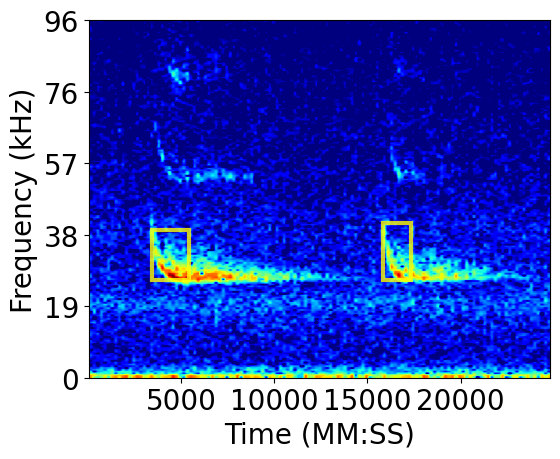

In [122]:
# start = 402.15
# duration = 0.35
start = 402.14
duration = 0.2
audio_file.seek(int(fs*start))
audio_bout = audio_file.read(int(fs*duration))

vmax = 20*np.log10(np.max(audio_bout)) # hide anything below -rm_dB dB
vmin = 20*np.log10(np.max(audio_bout)) - 40 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_bout
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
audio_features['figsize'] = (6, 5)

spec_features = dict()
spec_features['vmax'] = vmax
spec_features['vmin'] = vmin
spec_features['NFFT'] = 512
spec_features['cmap'] = 'jet'
audio_seg = audio_features['audio_seg']
fs = audio_features['sample_rate']
start = audio_features['start']
duration = audio_features['duration']

file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
UBNA_tz = pytz.timezone('US/Pacific')
UTC_tz = pytz.timezone('UTC')

file_dt_UTC = UTC_tz.localize(file_dt)
file_dt_PST = file_dt_UTC.astimezone(UBNA_tz)
file_title = f'{file_dt_PST.date()} {file_dt_PST.time()} PST'

plt.figure(figsize=audio_features['figsize'])
plt.rcParams.update({'font.size': 20})
# plt.title(f"BCI-derived bouts using BD2 detections on {audio_features['file_path'].name}", fontsize=22)
plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

legend_patches = []
for group in bout_params.keys():
    type_tag = group.split('_')[0]
    
    if group != 'site_key' and (type_tag in selected_bout['freq_group'].values):
        group_tag = group.split('_')[0]
        group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'{type_tag.upper()} Bout')
        legend_patches += [group_patch]

ax = plt.gca()
# plot_bout_info(ax, audio_features, selected_bout)
    
if len(plot_dets)>0:
    for i, row in plot_dets.iterrows():
        # if row['freq_group'] == selected_bout.iloc[0]['freq_group']:
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=3, edgecolor='yellow', facecolor='none', alpha=0.8)
    
        ax.add_patch(rect)

windows_PST = pd.date_range(file_dt_PST+pd.Timedelta(seconds=start), file_dt_PST+pd.Timedelta(seconds=start)+pd.Timedelta(seconds=duration), freq=f'{duration/4}S', inclusive='both')

plt.yticks(ticks=np.linspace(0, 1*(96/125), 6), labels=np.linspace(0, 192000/2000, 6).astype('int'))
# plt.xticks(ticks=np.linspace(0, duration*(fs/2), len(windows_PST)), labels=windows_PST.strftime('%S'), color='k')
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (MM:SS)")
plt.ylim(0, 96/125)
# plt.legend(handles=legend_patches, fontsize=14, ncol=int(len(legend_patches)), loc='upper right')

plt.tight_layout()
plt.show()

In [123]:
# start = 402.15
# duration = 0.35
start = 390
duration = 30
audio_file.seek(int(fs*start))
audio_bout = audio_file.read(int(fs*duration))

vmax = 20*np.log10(np.max(audio_bout)) # hide anything below -rm_dB dB
vmin = 20*np.log10(np.max(audio_bout)) - 60 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_bout
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration
audio_features['figsize'] = (6, 5)

spec_features = dict()
spec_features['vmax'] = vmax
spec_features['vmin'] = vmin
spec_features['NFFT'] = 512
spec_features['cmap'] = 'jet'

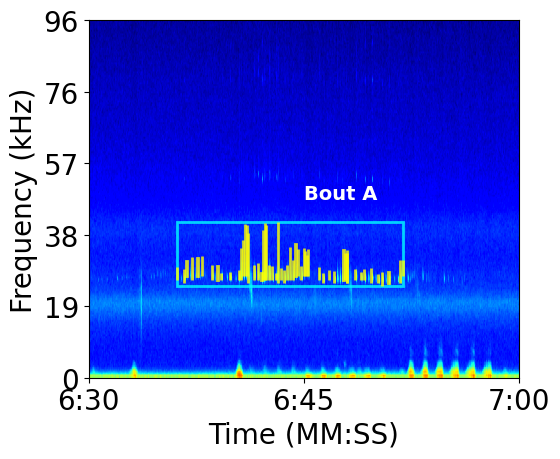

In [135]:
audio_seg = audio_features['audio_seg']
fs = audio_features['sample_rate']
start = audio_features['start']
duration = audio_features['duration']

file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
UBNA_tz = pytz.timezone('US/Pacific')
UTC_tz = pytz.timezone('UTC')

file_dt_UTC = UTC_tz.localize(file_dt)
file_dt_PST = file_dt_UTC.astimezone(UBNA_tz)
file_title = f'{file_dt_PST.date()} {file_dt_PST.time()} PST'

plt.figure(figsize=audio_features['figsize'])
plt.rcParams.update({'font.size': 20})
# plt.title(f"BCI-derived bouts using BD2 detections on {audio_features['file_path'].name}", fontsize=22)
plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

legend_patches = []
for group in bout_params.keys():
    type_tag = group.split('_')[0]
    
    if group != 'site_key' and (type_tag in selected_bout['freq_group'].values):
        group_tag = group.split('_')[0]
        group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'{type_tag.upper()} Bout')
        legend_patches += [group_patch]

ax = plt.gca()
plot_bout_info(ax, audio_features, selected_bout)
plt.text(x=0.5, y=0.5, s='Bout A', color='w', fontsize=14, fontweight='bold', transform=ax.transAxes)
    
if len(plot_dets)>0:
    for i, row in plot_dets.iterrows():
        if row['freq_group'] == selected_bout.iloc[0]['freq_group']:
            rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        
            ax.add_patch(rect)

windows_PST = pd.date_range(file_dt_PST+pd.Timedelta(seconds=start), file_dt_PST+pd.Timedelta(seconds=start)+pd.Timedelta(seconds=duration), freq=f'{duration/2}S', inclusive='both')

plt.yticks(ticks=np.linspace(0, 1*(96/125), 6), labels=np.linspace(0, 192000/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), len(windows_PST)), labels=windows_PST.strftime('%-M:%S'), color='k')
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (MM:SS)")
plt.ylim(0, 96/125)
# plt.legend(handles=legend_patches, fontsize=14, ncol=int(len(legend_patches)), loc='upper right')

plt.tight_layout()
plt.show()

In [22]:
site_key = 'Carp'
input_dir = Path(f'../data/detected_calls/{site_key}')
choice_type = 'top1_inbouts'
filter_settings = '6ms_nobandpass'
signals = 'call_signals'
filepath = input_dir / f'2022_bd2{site_key}_{choice_type}_{filter_settings}_{signals}.npy'
if (filepath).exists():
    print(site_key)
    location_call_signals = np.load(filepath, allow_pickle=True)
    print(location_call_signals.shape)
    call_info = pd.read_csv(input_dir / f'2022_bd2{site_key}_{choice_type}.csv', index_col=0, low_memory=False)
    call_info['index'] = call_info.index

Carp
(38693,)


In [79]:
file_calls = call_info.loc[(call_info['file_name']==audio_features['file_path'].name)&(call_info['freq_group']=='LF1')]
file_calls

index  start_time_wrt_ref  end_time_wrt_ref  index_in_file freq_group  \
9242   9242             91.7395           91.7531         242997        LF1   
9243   9243            304.5805          304.5959         243549        LF1   
9244   9244            336.8855          336.9025         243554        LF1   
9245   9245            347.6735          347.6918         243558        LF1   
9246   9246            372.8705          372.8869         243582        LF1   
...     ...                 ...               ...            ...        ...   
9320   9320           1728.2065         1728.2229         247015        LF1   
9321   9321           1735.8155         1735.8323         247027        LF1   
9322   9322           1742.8915         1742.9089         247041        LF1   
9323   9323           1773.9845         1774.0015         247119        LF1   
9324   9324           1789.7975         1789.8135         247166        LF1   

      index_in_file.1             ref_time             call_start_time  \
9242              236  2022-07-28 08:00:00  2022-07-28 08:01:31.739500   
9243              788  2022-07-28 08:00:00  2022-07-28 08:05:04.580500   
9244              793  2022-07-28 08:00:00  2022-07-28 08:05:36.885500   
9245              797  2022-07-28 08:00:00  2022-07-28 08:05:47.673500   
9246              821  2022-07-28 08:00:00  2022-07-28 08:06:12.870500   
...               ...                  ...                         ...   
9320             4254  2022-07-28 08:00:00  2022-07-28 08:28:48.206500   
9321             4266  2022-07-28 08:00:00  2022-07-28 08:28:55.815500   
9322             4280  2022-07-28 08:00:00  2022-07-28 08:29:02.891500   
9323             4358  2022-07-28 08:00:00  2022-07-28 08:29:33.984500   
9324             4405  2022-07-28 08:00:00  2022-07-28 08:29:49.797500   

                   call_end_time  start_time  ...  \
9242  2022-07-28 08:01:31.753100     91.7395  ...   
9243  2022-07-28 08:05:04.595900    304.5805  ...   
9244  2022-07-28 08:05:36.902500    336.8855  ...   
9245  2022-07-28 08:05:47.691800    347.6735  ...   
9246  2022-07-28 08:06:12.886900    372.8705  ...   
...                          ...         ...  ...   
9320  2022-07-28 08:28:48.222900   1728.2065  ...   
9321  2022-07-28 08:28:55.832300   1735.8155  ...   
9322  2022-07-28 08:29:02.908900   1742.8915  ...   
9323  2022-07-28 08:29:34.001500   1773.9845  ...   
9324  2022-07-28 08:29:49.813500   1789.7975  ...   

                                             input_file  Site name  \
9242  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
9243  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
9244  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
9245  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
9246  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
...                                                 ...        ...   
9320  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
9321  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
9322  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
9323  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   
9324  /mnt/ubna_data_01_mir/recover-20220728/UBNA_00...  Carp Pond   

        Recover Folder SD Card File Duration       cycle_ref_time        SNR  \
9242  recover-20220728       7        1795.0  2022-07-28 08:00:00  34.896104   
9243  recover-20220728       7        1795.0  2022-07-28 08:00:00  11.815704   
9244  recover-20220728       7        1795.0  2022-07-28 08:00:00  24.073305   
9245  recover-20220728       7        1795.0  2022-07-28 08:00:00  17.773388   
9246  recover-20220728       7        1795.0  2022-07-28 08:00:00  20.095352   
...                ...     ...           ...                  ...        ...   
9320  recover-20220728       7        1795.0  2022-07-28 08:00:00   3.885871   
9321  recover-20220728       7        1795.0  2022

In [80]:
chosen_call = file_calls.iloc[7]
chosen_call

index                                                              9249
start_time_wrt_ref                                             402.5685
end_time_wrt_ref                                               402.5847
index_in_file                                                    243652
freq_group                                                          LF1
index_in_file.1                                                     891
ref_time                                            2022-07-28 08:00:00
call_start_time                              2022-07-28 08:06:42.568500
call_end_time                                2022-07-28 08:06:42.584700
start_time                                                     402.5685
end_time                                                       402.5847
low_freq                                                        26328.0
high_freq                                                       30144.0
event                                                      Echol

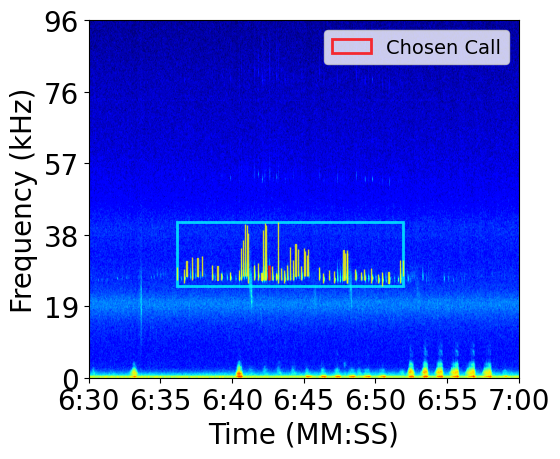

In [82]:
audio_seg = audio_features['audio_seg']
fs = audio_features['sample_rate']
start = audio_features['start']
duration = audio_features['duration']

file_dt = dt.datetime.strptime(audio_features['file_path'].name, '%Y%m%d_%H%M%S.WAV')
UBNA_tz = pytz.timezone('US/Pacific')
UTC_tz = pytz.timezone('UTC')

file_dt_UTC = UTC_tz.localize(file_dt)
file_dt_PST = file_dt_UTC.astimezone(UBNA_tz)
file_title = f'{file_dt_PST.date()} {file_dt_PST.time()} PST'

plt.figure(figsize=audio_features['figsize'])
plt.rcParams.update({'font.size': 20})
# plt.title(f"BCI-derived bouts using BD2 detections on {audio_features['file_path'].name}", fontsize=22)
plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

legend_patches = []
for group in bout_params.keys():
    type_tag = group.split('_')[0]
    
    if group != 'site_key' and (type_tag in plot_bouts['freq_group'].values):
        group_tag = group.split('_')[0]
        group_patch = patches.Patch(facecolor=FREQUENCY_COLOR_MAPPINGS[group_tag], edgecolor='k', label=f'{type_tag.upper()} Bouts')
        legend_patches += [group_patch]

ax = plt.gca()
plot_bout_info(ax, audio_features, selected_bout)
    
if len(plot_dets)>0:
    for i, row in plot_dets.iterrows():
        if row['freq_group'] == selected_bout.iloc[0]['freq_group']:
            if row['start_time']==chosen_call['start_time']:
                rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                                (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                                linewidth=2, edgecolor='red', facecolor='none', alpha=0.8, label='Chosen Call')
            else:
                rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                            (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                            linewidth=1, edgecolor='yellow', facecolor='none', alpha=0.8)
        
            ax.add_patch(rect)

windows_PST = pd.date_range(file_dt_PST+pd.Timedelta(seconds=start), file_dt_PST+pd.Timedelta(seconds=start)+pd.Timedelta(seconds=duration), freq=f'{duration//6}S', inclusive='both')

plt.yticks(ticks=np.linspace(0, 1*(96/125), 6), labels=np.linspace(0, 192000/2000, 6).astype('int'))
plt.xticks(ticks=np.linspace(0, duration*(fs/2), len(windows_PST)), labels=windows_PST.strftime('%-M:%S'), color='k')
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (MM:SS)")
plt.ylim(0, 96/125)
plt.legend(fontsize=14, loc='upper right')

plt.tight_layout()
plt.show()

In [165]:
def pad_call_ms(call, fs, window_dur):
    window_samples = int(fs*window_dur)
    call_samples = len(call)
    padded_call = np.pad(call, np.ceil((window_samples - call_samples)/2).astype(int), mode='constant', constant_values=1e-4)

    return padded_call

In [27]:
bout_dets = plot_dets.loc[(plot_dets['start_time']>=selected_bout.iloc[0]['start_time'])&(plot_dets['end_time']<=selected_bout.iloc[0]['end_time'])]
bout_dets.reset_index(drop=True, inplace=True)
bout_dets.shape

(56, 22)

In [83]:
chosen_call

index                                                              9249
start_time_wrt_ref                                             402.5685
end_time_wrt_ref                                               402.5847
index_in_file                                                    243652
freq_group                                                          LF1
index_in_file.1                                                     891
ref_time                                            2022-07-28 08:00:00
call_start_time                              2022-07-28 08:06:42.568500
call_end_time                                2022-07-28 08:06:42.584700
start_time                                                     402.5685
end_time                                                       402.5847
low_freq                                                        26328.0
high_freq                                                       30144.0
event                                                      Echol

In [153]:
def get_snr_from_band_limited_signal(snr_call_signal, snr_noise_signal): 

    signal_power_rms = np.sqrt(np.square(snr_call_signal).mean())
    noise_power_rms = np.sqrt(np.square(snr_noise_signal).mean())
    snr = abs(20 * np.log10(signal_power_rms / noise_power_rms))

    return snr


def bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff):
    nyq = fs // 2
    low_cutoff = (low_freq_cutoff) / nyq
    high_cutoff =  (high_freq_cutoff) / nyq
    b, a = scipy.signal.butter(4, [low_cutoff, high_cutoff], btype='band', analog=False)
    band_limited_audio_seg = scipy.signal.filtfilt(b, a, audio_seg)

    return band_limited_audio_seg

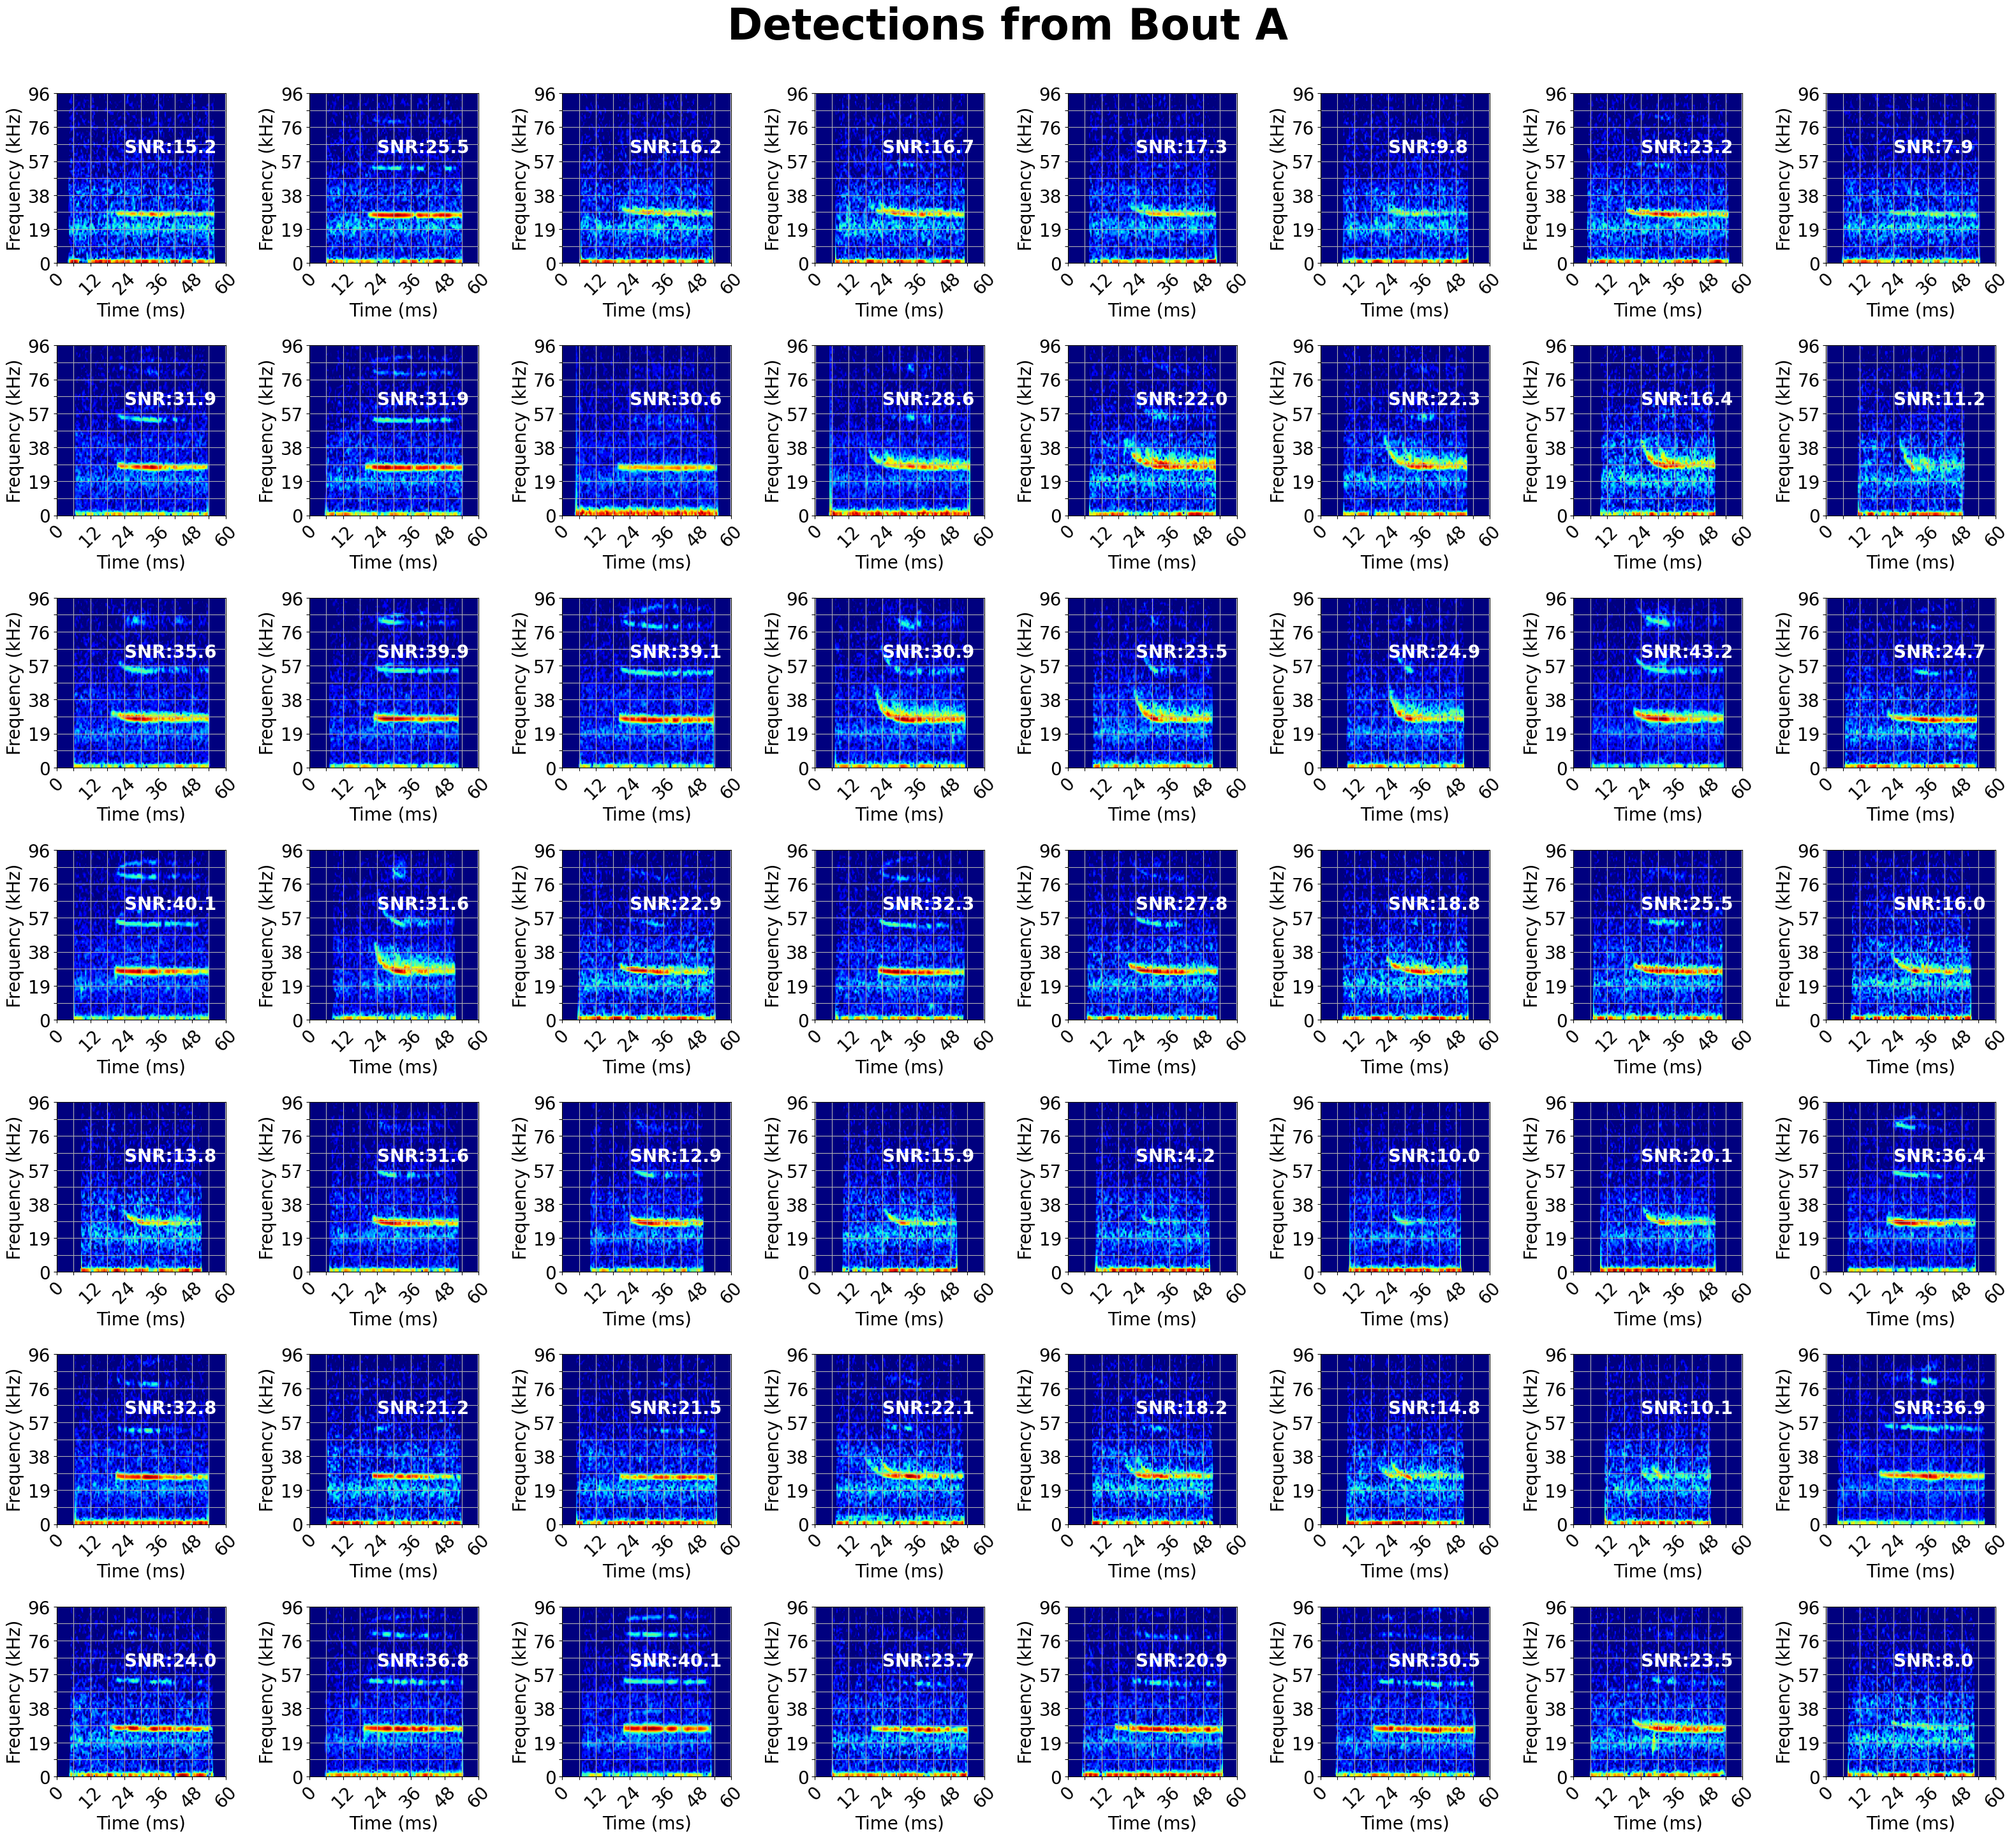

In [166]:
plt.figure(figsize=(4*len(bout_dets)/7,4*8))
plt.suptitle('Detections from Bout A', fontsize=48, weight='bold', y=1.0)
for i, row in bout_dets.iterrows():
    plt.subplot(8,len(bout_dets)//7,i+1)
    call_dur = (row['end_time'] - row['start_time'])
    pad = 0.002
    start = row['start_time'] - call_dur - (3*pad)
    duration = (2 * call_dur) + (4*pad)
    end = row['end_time']
    nyquist = fs/2
    if start >=0 and end <= 1795:
        audio_file.seek(int(fs*start))
        audio_seg = audio_file.read(int(fs*duration))
        
        low_freq_cutoff = row['low_freq']-2000
        high_freq_cutoff = min(nyquist-1, row['high_freq']+2000)
        band_limited_audio_seg = bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff)

        sec_length = int(fs*(pad+call_dur+pad))
        signal = band_limited_audio_seg.copy()
        signal[:sec_length] = 0

        noise = band_limited_audio_seg - signal
        snr_call_signal = signal[-sec_length:]
        snr_noise_signal = noise[:sec_length]
        snr = get_snr_from_band_limited_signal(snr_call_signal, snr_noise_signal)

        pad = 0.015
        audio_file.seek(int(fs*(row['start_time']-pad)))
        call_for_display = audio_file.read(int(fs*((row['end_time']-row['start_time'])+(2*pad))))
        padded_call = pad_call_ms(call_for_display, fs, 0.06)

        padded_call_dur = round(len(padded_call)/fs, 2)
        plt.specgram(padded_call, NFFT=256, cmap='jet', vmin=-55)
        time_labels = (np.linspace(0,1000*padded_call_dur, 11).astype('int')).astype('str')
        time_labels[1::2] = ''
        plt.xticks(ticks=np.linspace(0,round(len(padded_call)/2), 11), labels=time_labels, rotation=45)
        ax = plt.gca()
        plt.text(x=0.4, y=0.65, s=f'SNR:{round(snr, 1)}', color='white', fontsize=20, fontweight='bold', transform=ax.transAxes)

        low_end = 0
        high_end = 96000
        freq_labels = (np.linspace(low_end/1000, high_end/1000, 11)).astype('int').astype('str')
        freq_labels[1::2] = ''
        plt.yticks(ticks=np.linspace(2*low_end/(fs), 2*high_end/(fs), 11), labels=freq_labels)
        plt.ylim(2*low_end/(fs), 2*high_end/(fs))
        plt.xlabel('Time (ms)')
        plt.ylabel('Frequency (kHz)')
        plt.grid(which='both')

plt.tight_layout()
plt.show()